(### WARNING ### - do not use 2021-01-18_trySaturated.ipynb! It uses an older SaturationStacker pre bugfixes. Use this notebook instead.)

## Started 2021-03-24 - try assessing the saturation levels for a range of opsims ##

**2021-03-24** - copied from saturationstacker notebook. Started refactoring steps into a method that can be called each time through. Still under construction - **warning** this won't yet work on sciserver due to differences in the directory structure from Datalab.

**2021-03-24 4pm:** TODOS:

* Implement filter lists
* look into weighting by nstars (probably nstars in i-band)

In [1]:
# 2021-01-17 - try to run PY's new saturation stacker
#
# 2021-02-18 UPDATED with the corrected saturation stacker (there was a bug in the original).
# This new saturation stacker is in the github sims_maf (and was pasted here). When Datalab's
# version is updated to have this stacker, I will remove the corresponding cell in this notebook.
#
# THis is all pasted from a prototype notebook Peter Yoachim produced in response to queries.
#
# Updated with some syntax to find the dynamic range between the median saturation limit in the 
# short exposures and the coadded m5 depth in the long exposures. If there are no short exposures
# in the opsim, then the saturation limit is taken from the long exposures. If there are no long
# exposures then the m5 depth is taken from the short exposures. "Short" and "Long" are defined as 
# having total visit time less than or above timeCut = 20 seconds.

In [2]:
# import python pieces
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os, glob # for checking existence of db


In [3]:
# top level directory for opsim databases
#
# on sciserver
# dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  

# on datalab
dbroot='/sims_maf/fbs_1.5/short_exp/'

In [4]:
# for making a new metricBundle
import copy

In [5]:
# import lsst-relevant stuff
import lsst.sims.maf.stackers as stackers

In [6]:
class SaturationStacker(stackers.BaseStacker):
    """Calculate the saturation limit of a point source. Assumes Guassian PSF.
    
    Parameters
    ----------
    pixscale : float, opt (0.2)
        Arcsec per pixel
    gain : float, opt (2.3)
        electrons per adu
    saturation_e : float, opt (150e3)
        The saturation level in electrons
    zeropoints : dict-like, opt (None)
        The zeropoints for the telescope. Keys should be str with filter names, values in mags.
        If None, will use Rubin-like zeropoints.
    km : dict-like, opt (None)
        Atmospheric extinction values.  Keys should be str with filter names. If None, will use Rubin-like zeropoints.
    """
    colsAdded = ['saturation_mag']

    def __init__(self, seeingCol='seeingFwhmEff', skybrightnessCol='skyBrightness',
                 exptimeCol='visitExposureTime', nexpCol='numExposures',
                 filterCol='filter', airmassCol='airmass',
                 saturation_e=150e3, zeropoints=None, km=None, pixscale=0.2, gain=1.0):
        self.units = ['mag']
        self.colsReq = [seeingCol, skybrightnessCol, exptimeCol, nexpCol, filterCol, airmassCol]
        self.seeingCol = seeingCol
        self.skybrightnessCol = skybrightnessCol
        self.exptimeCol = exptimeCol
        self.nexpCol = nexpCol
        self.filterCol = filterCol
        self.airmassCol = airmassCol
        self.saturation_adu = saturation_e/gain
        self.pixscale = 0.2
        names = ['u', 'g', 'r', 'i', 'z', 'y']
        types = [float]*6
        if zeropoints is None:
            # Note these zeropoints are calculating the number of *electrons* per second (thus gain=1)
            # https://github.com/lsst-pst/syseng_throughputs/blob/master/notebooks/Syseng%20Throughputs%20Repo%20Demo.ipynb
            self.zeropoints = np.array([27.03, 28.38, 28.15, 27.86, 27.46, 26.68]).view(list(zip(names, types)))
            self.saturation_adu = saturation_e 
        else:
            self.zeropoints = zeropoints

        if km is None:
            # Also from notebook above
            self.km = np.array([0.491, 0.213, 0.126, 0.096, 0.069, 0.170]).view(list(zip(names, types)))
        else:
            self.km = km

    def _run(self, simData, cols_present=False):
        for filtername in np.unique(simData[self.filterCol]):
            in_filt = np.where(simData[self.filterCol] == filtername)[0]
            # Calculate the length of the on-sky time per EXPOSURE
            exptime = simData[self.exptimeCol][in_filt] / simData[self.nexpCol][in_filt]
            # Calculate sky counts per pixel per second from skybrightness + zeropoint (e/1s)
            sky_counts = 10.**(0.4*(self.zeropoints[filtername] - simData[self.skybrightnessCol][in_filt])) * self.pixscale**2
            # Total sky counts in each exposure 
            sky_counts = sky_counts * exptime
            # The counts available to the source (at peak) in each exposure is the difference between saturation and sky
            remaining_counts_peak = (self.saturation_adu - sky_counts)
            # Now to figure out how many counts there would be total, if there are that many in the peak
            sigma = simData[self.seeingCol][in_filt]/2.354
            source_counts = remaining_counts_peak * 2.*np.pi*(sigma/self.pixscale)**2
            # source counts = counts per exposure (expTimeCol / nexp)
            # Translate to counts per second, to apply zeropoint 
            count_rate = source_counts / exptime
            simData['saturation_mag'][in_filt] = -2.5*np.log10(count_rate) + self.zeropoints[filtername]
            # Airmass correction
            simData['saturation_mag'][in_filt] -= self.km[filtername]*(simData[self.airmassCol][in_filt] - 1.)

        return simData

In [7]:
def selectBrightnessKeys(bg=None, keySat='saturation_mag', keyDepth='CoaddM5'):
    
    """Determine which keys in the bundle dict to use for our 'short' and 'long' exposures"""

    # if a bundle group was not passed in, return dummy keywords that will fail later on.
    if bg is None:
        return 'DUMMY_sat', 'DUMMY_m5'
    
    # Below, we will use the saturation limit and the m5 limiting depth from the 
    # short or long exposures as appropriate. 
    #
    # which keys we use depends on whether there actually *were* "short" as 
    # well as "long" exposures in the opsim. There's probably a sims_maf-ish way 
    # to learn this, but for the moment we just determine which does not have 
    # "None" as the metricValues. We first learn which keys correspond to the 
    # pieces we want, then find out which are populated.

    # These dictionaries are keyed by the search terms in the bundle names.
    # For clarity let's just use one dictionary each for the saturation mag
    # and for the m5 magnitude keys. Doing things this way should allow us 
    # to make changes to the search string up above (e.g. by varying the 
    # filter) and everything from here down should be unaffected.
    keySats = {'lt':'DUMMY', 'gt':'DUMMY'}
    keyMags = {'lt':'DUMMY', 'gt':'DUMMY'}

    # Look for keys that have "lt" and "saturation_mag"
    for sKey in bg.bundleDict.keys():
        for sSz in keySats.keys():
            if sKey.find(sSz) > -1:
                if sKey.find(keySat) > -1:
                    keySats[sSz] = sKey[:]
                if sKey.find(keyDepth) > -1:
                    keyMags[sSz] = sKey[:]

    # Default bundles to use: short exp for saturation and long exp for m5 depth
    keySatUse = keySats['lt'][:]
    keyM5Use = keyMags['gt'][:]

    # If the short-exposure bundle has no metricValues, switch to the long-exposure
    if bg.bundleDict[keySatUse].metricValues is None:
        keySatUse = keySats['gt'][:]

    # if the long-exposure bundle has no metricValues, switch to the short-exposure
    if bg.bundleDict[keyM5Use].metricValues is None:
        keyM5Use = keyMags['lt'][:]
        
    return keySatUse, keyM5Use

In [8]:
# set up for lsst
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.plots as plots


In [9]:
# set the run name for this time round
run_path = 'short_exp_5ns_5expt_v1.5_10yrs.db'
run_name = run_path.split('/')[-1].split('_v')[0]

In [10]:
# Connect to the database (on sciserver)
# dbroot='/home/idies/workspace/lsst_cadence/FBS_1.5/'  # now selected farther up
# conn = db.OpsimDatabase(dbroot+run_path)  # whoops - redundant. Commented out.
outDir = 'satur_test'
resultsDb = db.ResultsDb(outDir=outDir)
nside = 64 

timeCut=20.
sFilter = 'r'

In [11]:
def evaluateBundleGroup(pathOpsim='DUMMY', outDir='satur_test', nside=64, timeCut=20., sFilter='r', \
                  doPlots=True, run_name=''):
    
    """Creates and evaluates the bundle group for a particular run"""
    
    ## Refactored from various cells in this notebook
    if not os.access(pathOpsim, os.R_OK):
        return None
    
    # if a run name was not supplied, make one up by parsing the path to the opsim
    if len(run_name) < 1:
        run_name = pathOpsim.split('/')[-1].split('_v')[0]
        
    print("####### INFO - run name:", run_name)
    
    bundleList = []
    
    # declare a few things
    stacker = SaturationStacker()
    metric = metrics.MedianMetric(col='saturation_mag')
    slicer = slicers.HealpixSlicer(nside=nside)
    summaryStats = [metrics.MedianMetric()]
    plotDict = {}
    plotFuncs = [plots.HealpixSkyMap()]
    resultsDb = db.ResultsDb(outDir=outDir)
    
    # Now we define the bundles for the four types: short+saturation, short+m5, long+saturation, long+m5
    sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))

    sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)
    bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
                                                 plotDict=plotDict,
                                                 summaryMetrics=summaryStats, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                stackerList=[stacker]))

    bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
                                                 plotDict=plotDict, plotFuncs=plotFuncs,
                                                 runName=run_name,
                                                 summaryMetrics=summaryStats))
    
    # actually run things
    conn = db.OpsimDatabase(pathOpsim)
    bd = metricBundles.makeBundlesDictFromList(bundleList)
    bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
    bg.runAll()
    
    if doPlots:
        bg.plotAll(closefigs=False)
    
    # returns the bundlegroup
    return bg
    

In [30]:
## This cell is useful to find out what paths are present.
ldum = glob.glob('/sims_maf/*/twi*_neo/*db')
ldum

['/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod1_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod2_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod3_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod4_v1.5_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern5_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern6_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern7_v1.7_10yrs.db']

In [31]:
# let's try a few paths for comparison. These paths are currently hardwired for DATALAB.
lBaseline = glob.glob('/sims_maf/fbs_1.7/baseline/*db')
lShort = glob.glob('/sims_maf/fbs_1.5/short_exp/*db')
lTwilight = glob.glob('/sims_maf/*/twi*_neo/*db')
lPaths = lTwilight + lBaseline + lShort
print("Paths for opsims:")
lPaths

Paths for opsims:


['/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod1_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod2_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod3_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/twilight_neo/twilight_neo_mod4_v1.5_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern3_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern4_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern5_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern6_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/twi_neo/twi_neo_pattern7_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp1_v1.7_10yrs.db',
 '/sims_maf/fbs_1.7/baseline/baseline_nexp2_v1.7_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_2ns_1expt_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_2ns_5expt_v1.5_10yrs.db',
 '/sims_maf/fbs_1.5/short_exp/short_exp_5ns_1expt_v1.

In [32]:
# Experiment with a loop through opsims
outDir = 'satur_test'
nside = 64 
timeCut=20.
sFilter = 'r'
lEvals = []
for pathOpsim in lPaths:
    # Create and evaluate the bundle group for this run
    bgroup = evaluateBundleGroup(pathOpsim, outDir, nside, timeCut, sFilter, False)
    
    # Assess which sets to use for the saturation limit and the m5 depth 
    keySatUse, keyM5Use = selectBrightnessKeys(bgroup)
        
    # pass the appropriate bundles up for computing results
    bundlesResults = {'run_name':bgroup.bundleDict[keySatUse].runName, \
                      'saturation':bgroup.bundleDict[keySatUse], \
                      'm5depth':bgroup.bundleDict[keyM5Use] }
    lEvals.append(bundlesResults)

####### INFO - run name: twilight_neo_mod1
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime > 20.0 for columns ['numExposures', 'skyBrightness', 'filter', 'visitExposureTime', 'seeingFwhmEff', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'airmass']
Found 374087 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_r_and_visitExposureTime_gt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_r_and_visitExposureTime_gt_20_0_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Querying database SummaryAllProps with constraint filter="r" and visitExposureTime < 20.0 for columns ['numExposures', 'skyBrightness', 'filter', 'visitExposureTime', 'seeingFwhmEff', 'fieldDec', 'fieldRA', 'fiveSigmaDepth', 'airmass']
Found 391607 visits
Running:  ['twilight_neo_mod1_Median_saturation_mag_r_and_visitExposureTime_lt_20_0_HEAL', 'twilight_neo_mod1_CoaddM5_r_a

INFO: twilight_neo_mod1 25541 37213
INFO: twilight_neo_mod2 24071 37186
INFO: twilight_neo_mod3 24021 37140
INFO: twilight_neo_mod4 23996 37136
INFO: twi_neo_pattern1 22747 34552
INFO: twi_neo_pattern2 22746 34499
INFO: twi_neo_pattern3 22707 34474
INFO: twi_neo_pattern4 22418 34348
INFO: twi_neo_pattern5 22622 34489
INFO: twi_neo_pattern6 22703 34443
INFO: twi_neo_pattern7 22521 34373
INFO: baseline_nexp1 12 32544
INFO: baseline_nexp2 309 32550
INFO: short_exp_2ns_1expt 32436 32548
INFO: short_exp_2ns_5expt 28639 32545
INFO: short_exp_5ns_1expt 32509 32544
INFO: short_exp_5ns_5expt 29859 32534


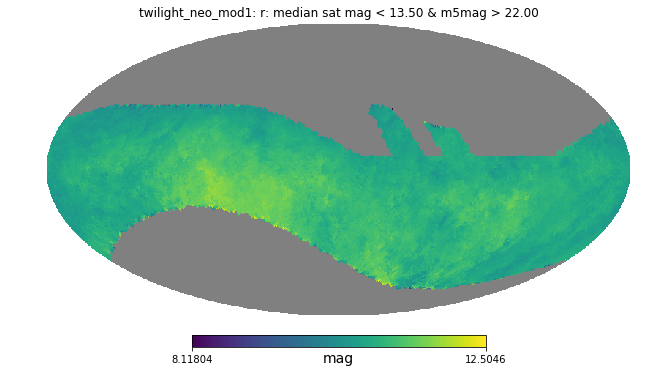

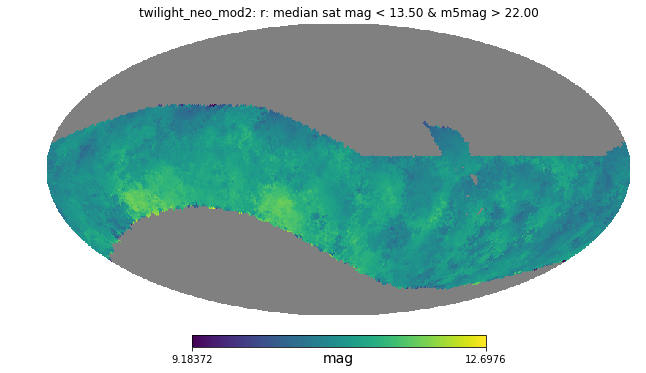

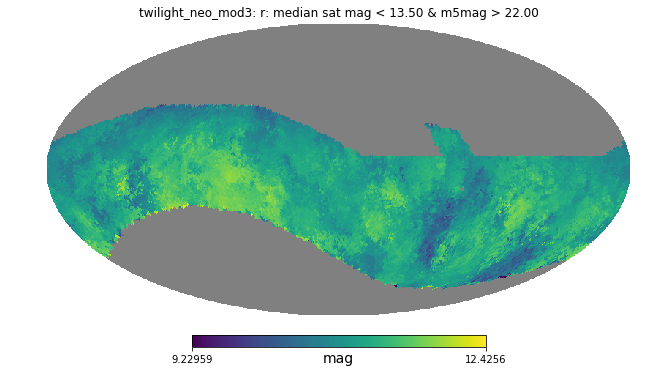

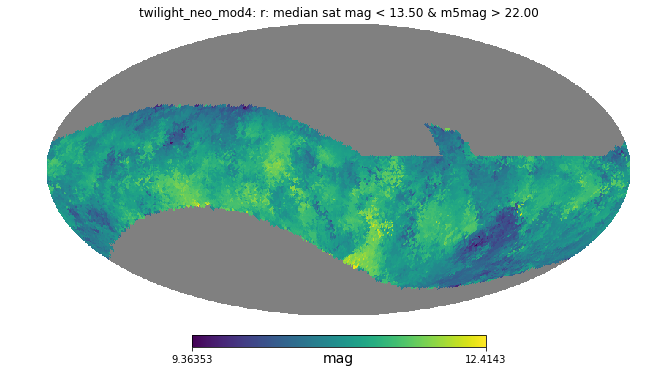

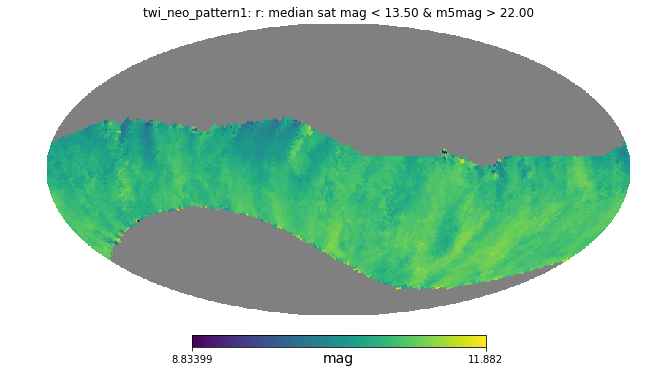

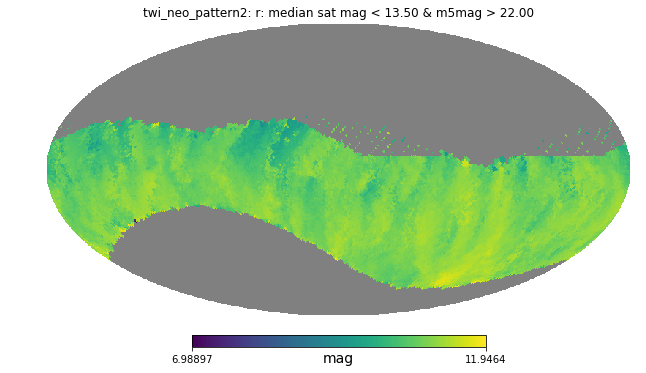

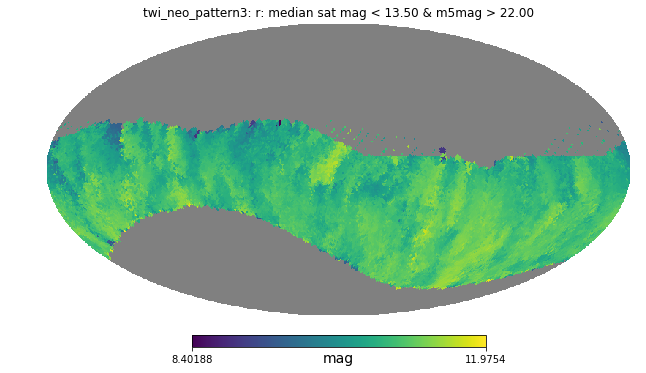

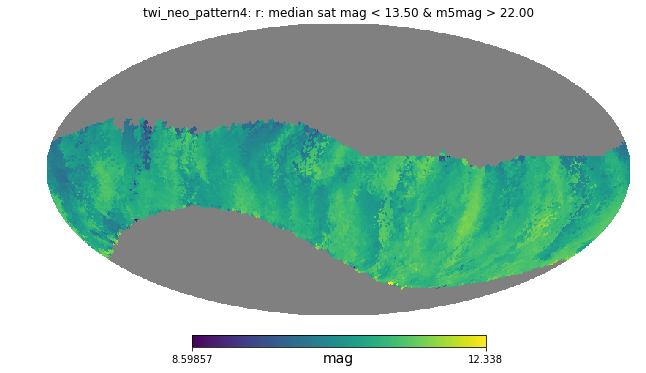

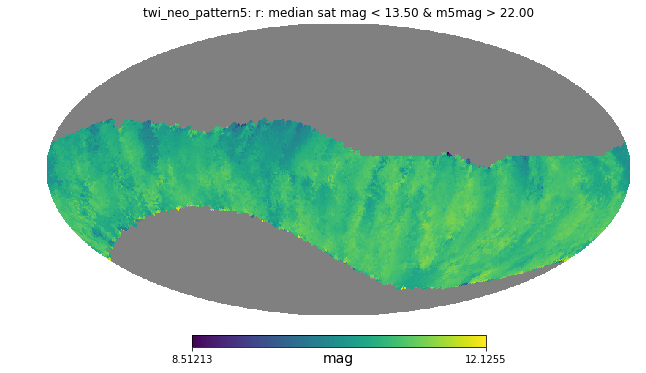

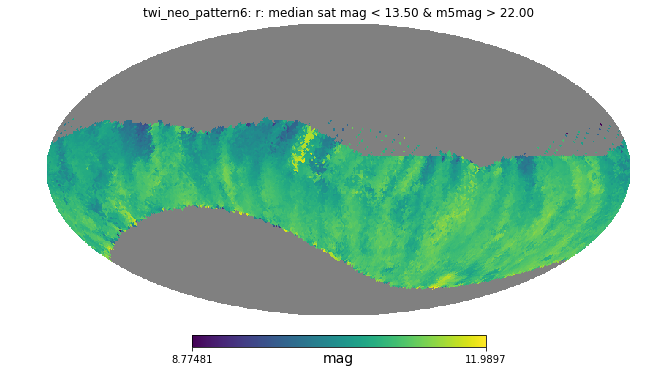

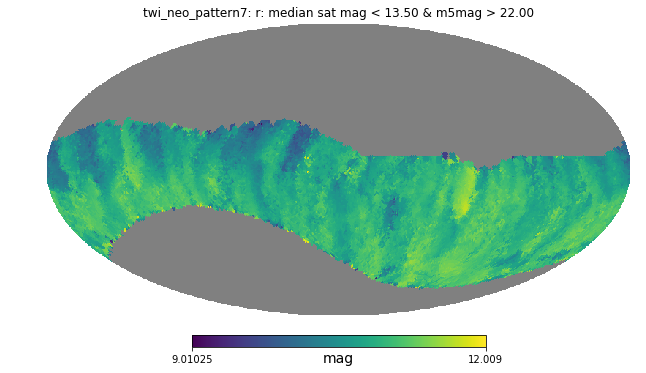

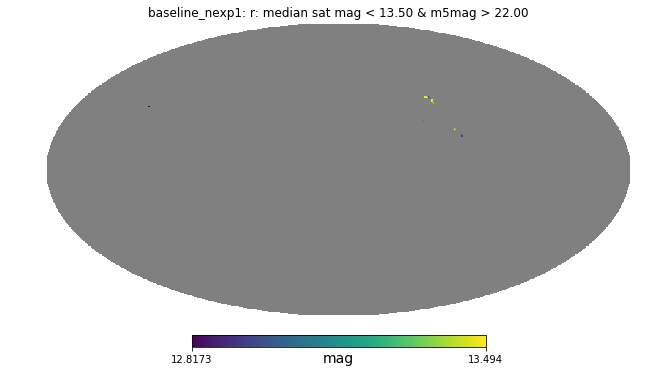

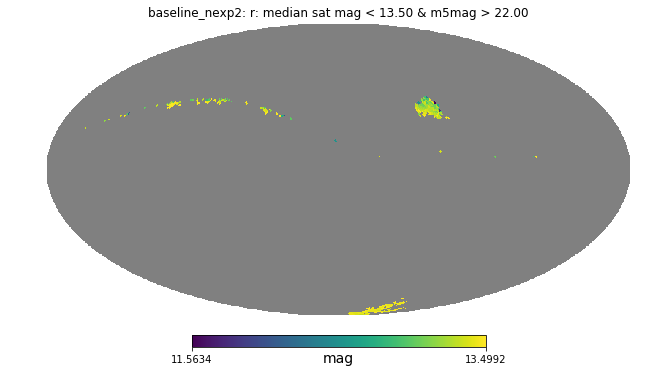

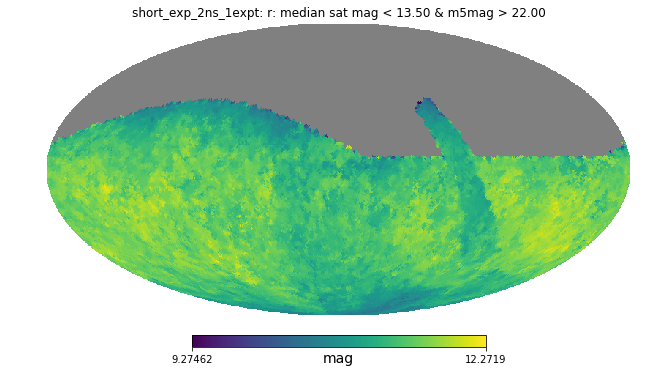

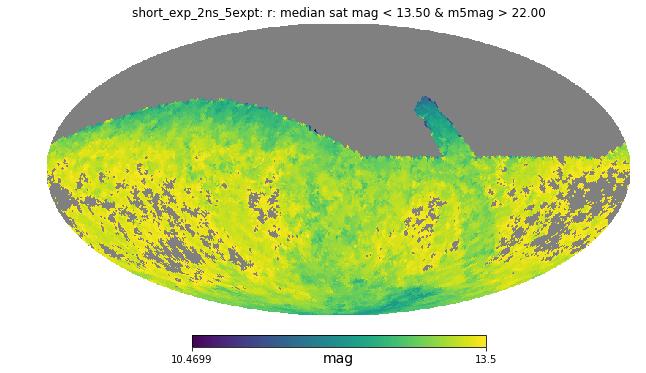

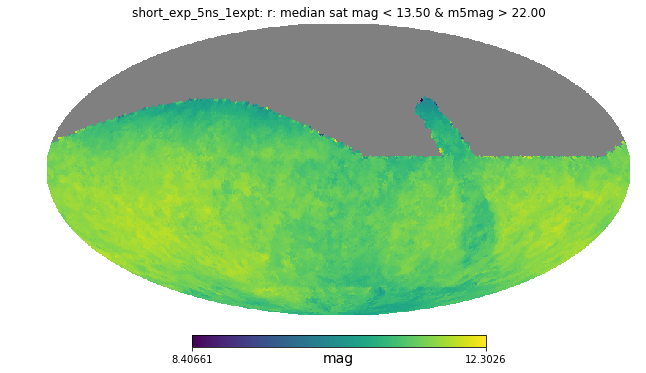

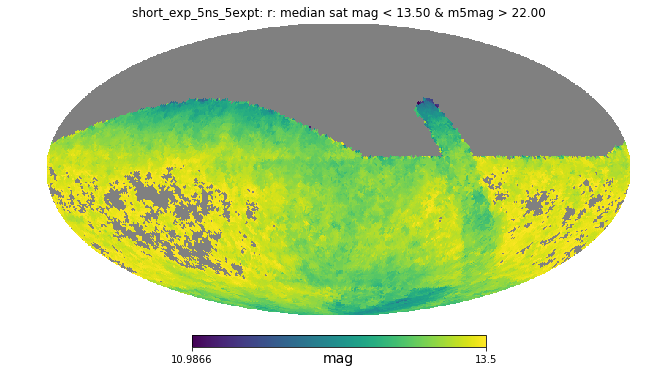

In [46]:
### Having assembled our set of bundles for the saturation and m5, now we evaluate the figure of merit
### for each run for the specified filter.
saturMax = 13.5
faintMin = 22.

# lists of results and run names
lFoms = []    # figure of merit
lNames = []   # run names
lEithers = [] # denominator - total area observed by either long or short sets 


# Title for the plots (so that we can use this later, outside this cell)
sConds = '%s: median sat mag < %.2f & m5mag > %.2f' % (sFilter, saturMax, faintMin)

for resDict in lEvals:
    
    # I think the best way to apply this is to find the fields that do NOT satisfy our criteria,
    # and add them to the mask. Let's try it.
    
    # For a denominator, let's count up the non-masked fields in the "long" exposure set. We do this before
    # messing with the short-exposure mask to guard against link-versus-copy confusion.
    # nDeep = np.sum(~resDict['m5depth'].metricValues.mask)
    
    # I think we can work with only the metric values here (mollview only needs the masked array). So:
    satur = np.ma.copy(resDict['saturation'].metricValues)
    faint = np.ma.copy(resDict['m5depth'].metricValues)
    
    # What is the total area occupied by either a long or a short exposure?
    nEither = np.sum( (~satur.mask) | (~faint.mask) )
    
    # For which fields is the saturation limit fainter than that requested?
    bSatBad = satur > saturMax
        
    # for which fields is the m5 limit brighter than that requested?
    bFainBad = faint < faintMin
    
    # OK now we update the mask of the saturated array
    satur.soften_mask()
    satur.mask = (satur.mask) | (bSatBad) | bFainBad
        
    # Count the number of fields that do not fail the condition...
    nNotFail = np.sum(~satur.mask)
    print("INFO:", resDict['run_name'], nNotFail, nEither)
    
    # ... and multiply by the healpix area. This is our figure of merit.
    pixDeg2 = hp.nside2pixarea(nside, degrees=True)
    areaGood = np.float(nNotFail)*pixDeg2
    areaTotal = np.float(nEither)*pixDeg2
    
    lFoms.append(areaGood)
    lNames.append(resDict['run_name'])
    lEithers.append(areaTotal)
    
    # can we just plot this?
    sTitle = '%s: %s' % (resDict['run_name'], sConds)
    hp.mollview(satur, unit='mag', title=sTitle)
    

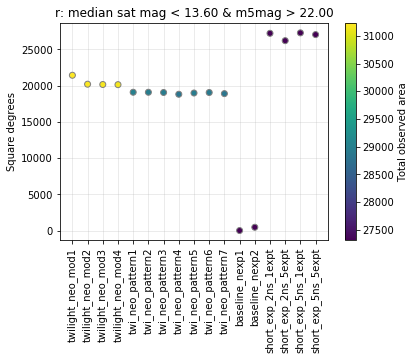

In [34]:
# OK now we have our figures of merit. Let's try plotting them as per Peter's Lots_of_runs.ipynb:
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
x = np.arange(len(lNames))
dum = ax1.scatter(x, lFoms, c=lEithers, edgecolor='0.5', zorder=2)
ax1.set_title(sConds)  # conditions label from above
ax1.set_ylabel('Square degrees')
ack = plt.xticks(x, lNames, rotation=90)
cbar = fig1.colorbar(dum, ax=ax1, label='Total observed area')
dum2 = ax1.grid(which='both', alpha=0.3, zorder=1)

In [35]:
# 2021-03-24 kept but commented out for the moment
#
## Define the metric bundle and the slicer
#bundleList = []

#stacker = SaturationStacker()

#sqlLong = 'filter="%s" and visitExposureTime > %.1f' % (sFilter, timeCut)
#metric = metrics.MedianMetric(col='saturation_mag')
#slicer = slicers.HealpixSlicer(nside=nside)
#summaryStats = [metrics.MedianMetric()]
#plotDict = {}
#plotFuncs = [plots.HealpixSkyMap()]
#bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlLong,
#                                             plotDict=plotDict,
#                                             summaryMetrics=summaryStats, plotFuncs=plotFuncs,
#                                            stackerList=[stacker]))

## Now find the median depth
#metricM5 = metrics.Coaddm5Metric('fiveSigmaDepth')
#bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlLong,
#                                             plotDict=plotDict, plotFuncs=plotFuncs,
#                                             summaryMetrics=summaryStats))

#sqlShort = 'filter="%s" and visitExposureTime < %.1f' % (sFilter, timeCut)

#bundleList.append(metricBundles.MetricBundle(metric,slicer,sqlShort,
##                                             plotDict=plotDict,
 #                                            summaryMetrics=summaryStats, plotFuncs=plotFuncs,
 #                                           stackerList=[stacker]))

#bundleList.append(metricBundles.MetricBundle(metricM5,slicer,sqlShort,
#                                             plotDict=plotDict, plotFuncs=plotFuncs, 
#                                             summaryMetrics=summaryStats))



In [36]:
## actually run things
#bd = metricBundles.makeBundlesDictFromList(bundleList)
#bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
#bg.runAll()
#bg.plotAll(closefigs=False)

In [37]:
## use our function to determine what classes of exposure we have
#keySatUse, keyM5Use = selectBrightnessKeys(bg)
#print("INFO - saturation will use %s" % (keySatUse))
#print("INFO - m5 coadd   will use %s" % (keyM5Use))

In [38]:
## find the difference: deep coadd m5 minus median saturation level
#valuesDiffs = bg.bundleDict[keyM5Use].metricValues - bg.bundleDict[keySatUse].metricValues

In [39]:
## 2021-03-24 based on Peter's "lots of runs" ipynb, it looks like we can append the bundles into a list
## and return those to extract results. This is nice because it allows us to interrogate the metric values
## themselves if we wish (e.g. to slice again spatially or on proposalID to avoid deep drilling. In my 
## head, this makes the most sense kept as a dictionary labeled by the run name, so that there's no danger
## that the orderings of any run name list sent into the putative function, and the list of results, 
## somehow end up in different order.)

## This is the thing that a function would return, one dictionary per run.
#bundlesResults = {'run_name':run_name, 'saturation':bg.bundleDict[keySatUse], 'm5depth':bg.bundleDict[keyM5Use] }

In [40]:
### loops would end here.

# TARGET: list of run names, list of entities from which we can extract single FoMs, one per run name.

In [41]:
#print(bundlesResults)

In [42]:
## HERE IS WHERE WE SHOW THE DYNAMIC RANGE. We ought to determine how we're going 
## to encode this into a figure of merit. Since we have our metric now as Healpix
## locations, this should (!) be relatively straightforward.
#dum = hp.mollview(valuesDiffs, title='Dynamic range')

In [43]:
#!pwd